In [0]:
#! wget -r -N -c -np -nv -q https://physionet.org/files/challenge-2017/1.0.0/

In [0]:
from google.colab import drive
#drive.mount('/content/drive')

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from scipy import signal
from tqdm import tqdm
import torch

if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("Running on GPU -", device )
else:
  device = torch.device("cpu")
  print("Running on CPU -", device )

# to run on gpu .to(device)

REBUILD_DATA = False # processing data

Running on GPU - cuda:0


In [0]:
"""
Copyright (c) 2013 Jami Pekkanen

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
"""

import sys
import numpy as np
import scipy.signal
import scipy.ndimage

def detect_beats(
		ecg,	# The raw ECG signal
		rate,	# Sampling rate in HZ
		# Window size in seconds to use for 
		ransac_window_size=5.0,
		# Low frequency of the band pass filter
		lowfreq=5.0,
		# High frequency of the band pass filter
		highfreq=15.0,
		):
	"""
	ECG heart beat detection based on
	http://link.springer.com/article/10.1007/s13239-011-0065-3/fulltext.html
	with some tweaks (mainly robust estimation of the rectified signal
	cutoff threshold).
	"""

	ransac_window_size = int(ransac_window_size*rate)

	lowpass = scipy.signal.butter(1, highfreq/(rate/2.0), 'low')
	highpass = scipy.signal.butter(1, lowfreq/(rate/2.0), 'high')
	# TODO: Could use an actual bandpass filter
	ecg_low = scipy.signal.filtfilt(*lowpass, x=ecg)
	ecg_band = scipy.signal.filtfilt(*highpass, x=ecg_low)
	
	# Square (=signal power) of the first difference of the signal
	decg = np.diff(ecg_band)
	decg_power = decg**2
	
	# Robust threshold and normalizator estimation
	thresholds = []
	max_powers = []
	for i in range(int(len(decg_power)/ransac_window_size)):
		sample = slice(i*ransac_window_size, (i+1)*ransac_window_size)
		d = decg_power[sample]
		thresholds.append(0.5*np.std(d))
		max_powers.append(np.max(d))

	threshold = np.median(thresholds)
	max_power = np.median(max_powers)
	decg_power[decg_power < threshold] = 0

	decg_power /= max_power
	decg_power[decg_power > 1.0] = 1.0
	square_decg_power = decg_power**2

	shannon_energy = -square_decg_power*np.log(square_decg_power)
	shannon_energy[~np.isfinite(shannon_energy)] = 0.0

	mean_window_len = int(rate*0.125+1)
	lp_energy = np.convolve(shannon_energy, [1.0/mean_window_len]*mean_window_len, mode='same')
	#lp_energy = scipy.signal.filtfilt(*lowpass2, x=shannon_energy)
	
	lp_energy = scipy.ndimage.gaussian_filter1d(lp_energy, rate/8.0)
	lp_energy_diff = np.diff(lp_energy)

	zero_crossings = (lp_energy_diff[:-1] > 0) & (lp_energy_diff[1:] < 0)
	zero_crossings = np.flatnonzero(zero_crossings)
	zero_crossings -= 1
	return zero_crossings

In [0]:
class Data_PreProcessing():
  ECG_PADDING = 90
  ECG_LENGTH = ECG_PADDING*2
  DATA = "physionet.org/files/challenge-2017/1.0.0/training/"
  NORMAL = "physionet.org/files/challenge-2017/1.0.0/training/RECORDS-normal" 
  AF = "physionet.org/files/challenge-2017/1.0.0/training/RECORDS-af"
  OTHER = "physionet.org/files/challenge-2017/1.0.0/training/RECORDS-other"
  NOISY = "physionet.org/files/challenge-2017/1.0.0/training/RECORDS-noisy"
  LABELS = {NORMAL: 0, AF: 1, OTHER:2, NOISY: 3}
  trainingData = []
  dataCount = {NORMAL: 0, AF: 0, OTHER: 0, NOISY: 0}


  def make_training_data(self):
    for records in self.LABELS:
      with open(records) as label:
        for ecgFile in tqdm(label):

          path = self.DATA+ecgFile[:-1]
          metadata = open(path+".hea", "r").read().split(" ")
          ecg_list = loadmat(path)['val'][0]

          for peak in detect_beats(ecg_list, float(metadata[2])):
            try:
              ecg = np.array(ecg_list[peak-self.ECG_PADDING:peak+self.ECG_PADDING])
              ecg = ecg / np.amax(abs(ecg))

              ecg = self.zero_padding(ecg) # what to call for fucntion
              
              augmented_ecg = self.zero_padding(self.resampling(self.rnd_zero(ecg)))

              if 17220 > self.dataCount[records]:
                #self.trainingData.append([ecgWave, self.LABELS[records]]) # CrossEntropyLoss()
                self.trainingData.append([ecg, np.eye(len(self.LABELS))[self.LABELS[records]]]) # MSELoss()
                self.trainingData.append([augmented_ecg, np.eye(len(self.LABELS))[self.LABELS[records]]])
                self.dataCount[records] += 2
                if len(ecg) == 0 or len(augmented_ecg) == 0:
                  print("FALSE")
            except Exception as e:
              #print(e)
              pass
    print(self.dataCount)
    total = sum(self.dataCount.values())
    for lbl in self.dataCount:
      print(lbl[80:]+": ", round(self.dataCount[lbl]/total*100, 2))
    print("Total: "+ str(total))

    np.random.shuffle(self.trainingData)
    np.save("trainingData.npy", self.trainingData)

  def rnd_zero(self, ecg):
    peak = np.argmax(ecg)
    for x in range(np.random.randint(5)):
      try:
        if np.random.randint(2) == 0:
          end = np.random.randint(peak-15)
          length = np.random.randint(7)+5
          ecg[end-length:end] = [0]*length
        else:
          start = np.random.randint(92)+115
          length = np.random.randint(7)+5
          ecg[start:start+length] = [0]*length
      except:
        pass
    return ecg

  def resampling(self, ecg):
	  MARGIN = 60
	  return signal.resample(ecg, np.random.randint(MARGIN)+(self.ECG_LENGTH-MARGIN))
   
  def zero_padding(self, ecg):
    if len(ecg) != self.ECG_LENGTH:
      ecg = np.append(ecg, [0]*(self.ECG_LENGTH-len(ecg)))
    return ecg

data = Data_PreProcessing()

if REBUILD_DATA:
  data.make_training_data()

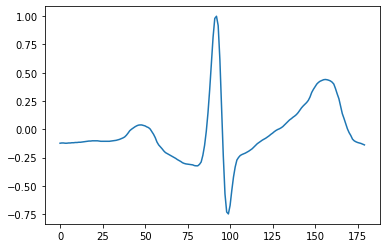

In [6]:
try:
  trainingData = np.load("trainingData.npy", allow_pickle=True)
  np.random.shuffle(trainingData)
except:
  trainingData = np.load("/content/drive/My Drive/trainingData.npy", allow_pickle=True)
  np.random.shuffle(trainingData)

ecg = trainingData[10][0]
plt.plot(ecg)


In [7]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__() # just run the init of parent class (nn.Module)
        self.conv1 = nn.Conv1d(1, 180, 5) # input is 1 image, 32 output channels, 5x5 kernel / window
        self.conv2 = nn.Conv1d(180, 360, 5) # input is 32, bc the first layer output 32. Then we say the output will be 64 channels, 5x5 kernel / window
        self.conv3 = nn.Conv1d(360, 720, 5)
        self.conv4 = nn.Conv1d(720, 1080, 5)
        self.conv5 = nn.Conv1d(1080, 1440, 5)


        x = torch.randn(1,1,180).view(-1,1,180)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 128) #flattening.
        self.fc2 = nn.Linear(128, 4) # 512 in, 2 out bc we're doing 2 classes (dog vs cat).

    def convs(self, x):
        x = F.max_pool1d(F.relu(self.conv1(x)), 2) # adjust shape of pooling?
        x = F.max_pool1d(F.relu(self.conv2(x)), 2) # x = F.max_pool1d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool1d(F.relu(self.conv3(x)), 2)
        x = F.max_pool1d(F.relu(self.conv4(x)), 2)
        x = F.max_pool1d(F.relu(self.conv5(x)), 2)

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  # .view is reshape ... this flattens X before 
        #x = x.view(-1, 2294784)
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # bc this is our output layer. No activation here.
        return x


net = Net().to(device)
print(net)

Net(
  (conv1): Conv1d(1, 180, kernel_size=(5,), stride=(1,))
  (conv2): Conv1d(180, 360, kernel_size=(5,), stride=(1,))
  (conv3): Conv1d(360, 720, kernel_size=(5,), stride=(1,))
  (conv4): Conv1d(720, 1080, kernel_size=(5,), stride=(1,))
  (conv5): Conv1d(1080, 1440, kernel_size=(5,), stride=(1,))
  (fc1): Linear(in_features=1440, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)


In [8]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr = 0.001)#, weight_decay=1e-5)
loss_function = nn.CrossEntropyLoss().to(device)

X = torch.Tensor([i[0] for i in trainingData])
y = torch.Tensor([i[1] for i in trainingData])
 
VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
print(val_size)

6888


In [9]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]
print(len(train_X), len(test_X))

61992 6888


In [10]:

def accuracy_test(dataset):
  if dataset == "train":
    X = train_X[:len(test_X)]
    y = train_y[:len(test_X)]
  elif dataset == "test":
    X = test_X
    y = test_y

  correct = 0
  total = 0
  with torch.no_grad():
      for i in tqdm(range(len(X))):
          real_class = torch.argmax(y[i]).to(device)
          net_out = net(X[i].view(-1,1,180).to(device))[0]  # returns a list
          predicted_class = torch.argmax(net_out)

          #print(real_class, predicted_class)
          if predicted_class == real_class:
              correct += 1
          total += 1
  return round(correct/total, 3)
'''

def accuracy_test():
  correct = 0
  total = 0
  with torch.no_grad():
      for i in tqdm(range(len(train_X))):
          real_class = torch.argmax(train_y[i]).to(device)
          net_out = net(train_y[i].view(-1,1,180).to(device))[0]  # returns a list
          predicted_class = torch.argmax(net_out)

          #print(real_class, predicted_class)
          if predicted_class == real_class:
              correct += 1
          total += 1
  return round(correct/total, 3)
'''

'\n\ndef accuracy_test():\n  correct = 0\n  total = 0\n  with torch.no_grad():\n      for i in tqdm(range(len(train_X))):\n          real_class = torch.argmax(train_y[i]).to(device)\n          net_out = net(train_y[i].view(-1,1,180).to(device))[0]  # returns a list\n          predicted_class = torch.argmax(net_out)\n\n          #print(real_class, predicted_class)\n          if predicted_class == real_class:\n              correct += 1\n          total += 1\n  return round(correct/total, 3)\n'

  0%|          | 0/13 [00:00<?, ?it/s]


Epoch: 0. Loss: 1.1835452318191528. Accuracy (training): 0.443. Accuracy (test): 0.445


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch: 1. Loss: 1.170567512512207. Accuracy (training): 0.466. Accuracy (test): 0.47


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch: 2. Loss: 1.0979586839675903. Accuracy (training): 0.519. Accuracy (test): 0.519


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch: 3. Loss: 1.0239207744598389. Accuracy (training): 0.555. Accuracy (test): 0.557


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch: 4. Loss: 1.0004152059555054. Accuracy (training): 0.572. Accuracy (test): 0.561


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch: 5. Loss: 0.9581871628761292. Accuracy (training): 0.594. Accuracy (test): 0.584


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch: 6. Loss: 0.9239460229873657. Accuracy (training): 0.596. Accuracy (test): 0.583


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch: 7. Loss: 0.8970868587493896. Accuracy (training): 0.616. Accuracy (test): 0.607


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch: 8. Loss: 0.8726398348808289. Accuracy (training): 0.624. Accuracy (test): 0.61


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch: 9. Loss: 0.8245865702629089. Accuracy (training): 0.644. Accuracy (test): 0.625


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch: 10. Loss: 0.7969616055488586. Accuracy (training): 0.647. Accuracy (test): 0.632


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch: 11. Loss: 0.7502543330192566. Accuracy (training): 0.658. Accuracy (test): 0.639


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch: 12. Loss: 0.733095109462738. Accuracy (training): 0.68. Accuracy (test): 0.652


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch: 13. Loss: 0.6852790713310242. Accuracy (training): 0.69. Accuracy (test): 0.656


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch: 14. Loss: 0.6799667477607727. Accuracy (training): 0.68. Accuracy (test): 0.651


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch: 15. Loss: 0.6414915323257446. Accuracy (training): 0.697. Accuracy (test): 0.661


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch: 16. Loss: 0.5710675120353699. Accuracy (training): 0.706. Accuracy (test): 0.662


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch: 17. Loss: 0.5352707505226135. Accuracy (training): 0.722. Accuracy (test): 0.668


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch: 18. Loss: 0.4978063404560089. Accuracy (training): 0.733. Accuracy (test): 0.673


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch: 19. Loss: 0.5192179083824158. Accuracy (training): 0.706. Accuracy (test): 0.646


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch: 20. Loss: 0.4735517203807831. Accuracy (training): 0.735. Accuracy (test): 0.662


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch: 21. Loss: 0.42786115407943726. Accuracy (training): 0.756. Accuracy (test): 0.668


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch: 22. Loss: 0.37145325541496277. Accuracy (training): 0.763. Accuracy (test): 0.68


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch: 23. Loss: 0.4158686697483063. Accuracy (training): 0.744. Accuracy (test): 0.666


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch: 24. Loss: 0.3800649046897888. Accuracy (training): 0.781. Accuracy (test): 0.68


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch: 25. Loss: 0.3106439411640167. Accuracy (training): 0.793. Accuracy (test): 0.673


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch: 26. Loss: 0.30391988158226013. Accuracy (training): 0.806. Accuracy (test): 0.688


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch: 27. Loss: 0.34546178579330444. Accuracy (training): 0.806. Accuracy (test): 0.677


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch: 28. Loss: 0.25178664922714233. Accuracy (training): 0.782. Accuracy (test): 0.667


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch: 29. Loss: 0.275755912065506. Accuracy (training): 0.818. Accuracy (test): 0.682


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch: 30. Loss: 0.2240012288093567. Accuracy (training): 0.835. Accuracy (test): 0.677


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch: 31. Loss: 0.16192489862442017. Accuracy (training): 0.855. Accuracy (test): 0.681


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch: 32. Loss: 0.14451178908348083. Accuracy (training): 0.872. Accuracy (test): 0.691


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch: 33. Loss: 0.12736037373542786. Accuracy (training): 0.85. Accuracy (test): 0.672


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch: 34. Loss: 0.1693306416273117. Accuracy (training): 0.866. Accuracy (test): 0.683


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch: 35. Loss: 0.172291561961174. Accuracy (training): 0.809. Accuracy (test): 0.649


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch: 36. Loss: 0.1635250747203827. Accuracy (training): 0.83. Accuracy (test): 0.659


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch: 37. Loss: 0.18720203638076782. Accuracy (training): 0.889. Accuracy (test): 0.7


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch: 38. Loss: 0.10472028702497482. Accuracy (training): 0.888. Accuracy (test): 0.694


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch: 39. Loss: 0.08059591054916382. Accuracy (training): 0.897. Accuracy (test): 0.682


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch: 40. Loss: 0.06665831059217453. Accuracy (training): 0.916. Accuracy (test): 0.687


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch: 41. Loss: 0.08952514827251434. Accuracy (training): 0.88. Accuracy (test): 0.672


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch: 42. Loss: 0.11614479869604111. Accuracy (training): 0.881. Accuracy (test): 0.672


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch: 43. Loss: 0.19498570263385773. Accuracy (training): 0.881. Accuracy (test): 0.676


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch: 44. Loss: 0.09528779238462448. Accuracy (training): 0.901. Accuracy (test): 0.68


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch: 45. Loss: 0.09349885582923889. Accuracy (training): 0.902. Accuracy (test): 0.685


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch: 46. Loss: 0.11960816383361816. Accuracy (training): 0.865. Accuracy (test): 0.669


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch: 47. Loss: 0.1409067064523697. Accuracy (training): 0.889. Accuracy (test): 0.674


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch: 48. Loss: 0.07321102917194366. Accuracy (training): 0.939. Accuracy (test): 0.695


100%|██████████| 6888/6888 [00:15<00:00, 436.89it/s]



Epoch: 49. Loss: 0.03892391547560692. Accuracy (training): 0.946. Accuracy (test): 0.696


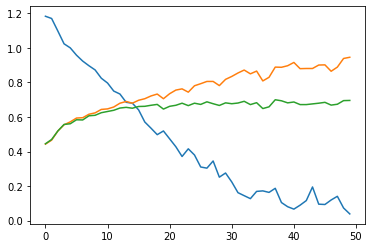

In [12]:
import matplotlib.pyplot as plt

BATCH_SIZE = 5000
EPOCHS = 50
lossList = []
accuracyTrain = []
accuracyTest = []


for epoch in range(EPOCHS):
  for i in tqdm(range(0, len(train_X), BATCH_SIZE)): # from 0, to the len of x, stepping BATCH_SIZE at a time. [:50] ..for now just to dev
    #print(f"{i}:{i+BATCH_SIZE}")
    batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,180).to(device)
    batch_y = train_y[i:i+BATCH_SIZE].to(device)

    net.zero_grad()

    outputs = net(batch_X)
    #loss = loss_function(outputs, batch_y.long())
    loss = loss_function(outputs, torch.argmax(batch_y, 1))
    loss.backward()
    optimizer.step()    # Does the update
  
  accTrain = accuracy_test("train")
  accTest = accuracy_test("test")
  print(f"\nEpoch: {epoch}. Loss: {loss}. Accuracy (training): {accTrain}. Accuracy (test): {accTest}")
  lossList.append([epoch, float(loss)])
  accuracyTrain.append([epoch, float(accTrain)])
  accuracyTest.append([epoch, float(accTest)])


lossList = list(map(list, zip(*lossList)))
accuracyTrain = list(map(list, zip(*accuracyTrain)))
accuracyTest = list(map(list, zip(*accuracyTest)))

plt.plot(lossList[0], lossList[1])
plt.plot(accuracyTrain[0], accuracyTrain[1])
plt.plot(accuracyTest[0], accuracyTest[1])

In [0]:
torch.save(net, '/content/drive/My Drive/tensor.pt')

In [0]:
 # insample accuracy & insample loss
 # outsample accuracy & outsample loss

def fwd_pass(X, y, train=False):
  if train:
    net.zero_grad()
  outputs = net(X)
  matches = [torch.argmax(i) == torch.argmax(j) for i,j in zip(outputs,y)]
  acc = matches.count(True)/len(matches)
  loss = loss_function(outputs, torch.argmax(batch_y, 1))
  if train:
    loss.backward()
    optimizer.step()
  return acc, loss

def test(size=996):
  X, y = test_X[:size], test_y[:size]
  with torch.no_grad():
    val_acc, val_loss = fwd_pass(X.view(-1, 1, 180).to(device), y.to(device))
  return val_acc, val_loss

print(test())

In [0]:
import time

MODEL_NAME = f"model-{time.time()}, layers-7"
net = Net()
optimizer = optim.Adam(net.parameters(), lr = 0.001)
loss_function = nn.CrossEntropyLoss().to(device)

print(MODEL_NAME)
  
def train():
  BATCH_SIZE = 1000
  EPOCHS = 5

  with open("model.log", "a") as f:
    for epoch in range(EPOCHS):
      for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,180).to(device)
        batch_y = train_y[i:i+BATCH_SIZE].to(device)

        acc, loss = fwd_pass(batch_X, batch_y, train=True)
        if i % 50 == 0:
          val_acc, val_loss = test(size=100)
          f.write(f"{MODEL_NAME}, {round(time.time(), 4)}, ACC:{round(float(acc),2)}, LOSS:{round(float(loss), 5)}, VAL_ACC:{round(float(val_acc),2)}, VAL_LOSS:{round(float(val_loss), 5)}\n")
  torch.save(x, f'{MODEL_NAME}.pt')

train()